In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import os

Taking the Csv output and producing the primary dataframe(s)

For my case, the Csv output is generated by going into the command line with the following steps:

1) cd to location of tomogram _even.mod file

2) imodinfo -a (tomogram_name)_even.mod > (root filepath)/addmodpts_data/(tomogram_name)_even.txt

    imodinfo -a generates a text file output
    the filename of the model file must include .mod
    the output filename must be given after > or the original model file may be altered

3) source addPts.sh 
    
    (once per session); this contains a function for applying addModPts manually

4) addpoints (tomogram name) X

    This function is contained in the addPts.sh file, and takes the tomogram name and number of cells with CdrA (X) as inputs. 
    
    This function assumes that objects containing CdrA alternate with those containing membrane patches as described below, with the first object in the tomogram being the first object containing CdrA. It then extracts the required objects, adds points to them, then recompiles the model into the same directory with the new structure (tomogram_name)_CdrA.mod

5) rm \*obj\*
    
    Removes all the intermediate files produced by the addpoints function

6) imodinfo -a (tomogram_name)_CdrA.mod > (root filepath)/Raw_data/(tomogram_name)_CdrA.txt



For the code to work, the data must be collected in a specific fashion:

1) A CdrA molecule or base membrane patch is modeled as a contour 
    
    A)  every CdrA molecule is defined from base to tip
    
    B)  every membrane patch is defined as a snake, with 3 points counted on each plane. Adjacent planes are 5 z stacks apart. collection goes -> -> -> /|\ <- <- \|/ -> -> giving 9 points per membrane patch 

2) All the CdrA molecules belonging to a given cell are part of the same object

3) To match membrane patches and CdrA molecules easily, they are collected in the same order and the objects corresponding to the same cell are numbered adjacently

    ie, if the first cell has 9 CdrA molecules, this will be the first object (with each molecule being a contour), with the second object being the 9 corresponding membrane patches
   
4) Objects must be named in a semi-standardised way:

    CdrA is only used in the name of objects containing CdrA molecules, and must be correctly capitalised

    The word 'object' should not be used - this is important to count cell number

    The word 'membrane' should feature in (and only in) membrane patch objects

5) File names should take the format {tomogram_name}_CdrA.txt or {tomogram_name}_even.txt

    The former is for after processing by AddModPts

    The latter is for the raw data as AddModPts creates some issues. First, it alters the total length of the molecules by making the last point further away. Second, sometimes points are added with extremely small separation (~0.5 nm) which ruins curvature calculations - my only current solution is to look though the interpoint distances and curvatures (calculated below) and 
    remove exceptions mannually, then recreate the txt files. This is annoying, but happens in only ~4 places in the 15 tomograms so far. Because of these issues, the majority of analysis is done with the normal points, and only curvature and plotting is done with resampled data


In [63]:
#Variables
tomograms = ['d01t11','d01t22','d01t23','d01t28','d01t29','d01t32','d01t33','d02t02','d04t05','d04t19','d04t20','d04t22','d04t25','d05t05']
#This scale factor converts the distances in pixels to nm - given by the file, potentially should be added to the dataframe
scale = 0.852
cdra_root = "C:/Users/callu/OneDrive/Desktop/Python scripts/"
cdra_filepath = r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA.csv"
cdra_M_filepath = r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA_M.csv"
membrane_filepath = r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA_membranes.csv"
addpts_filepath = r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA_resampled.csv"
radii_filepath = r"C:\Users\callu\OneDrive\Desktop\Python scripts\radii.csv"
#NB increment for radii calculation is defined in its cell
cdra_plt_filepath = r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA_plot.csv"

In [64]:
#Function to process CdrA data from text file
def CdrA_processing(filepath, Tomogram, outpath):
    """Takes a text filepath and Tomogram name of the file, and appends it to the csv given by outpath"""
    #There is no return as the function is outputting to the csv file

    #Initial parameters are set to OFF/0
    record_lines=False
    Number_objects = 0
    Correct_object=False    
    
    #With is used so that the file will be closed after the function is finished
    with open(filepath) as f:
        #The code iterates through every line in the text file
        for line in f:

            #This first step finds the first incidence of object, sets the correct_object paramter to false as a baseline
            if "object" in line:
                Correct_object = False
            
            #This function records the CdrA molecule of interest, so it starts considering if data should be recorded when CdrA is observed after object - ie an object named with 'CdrA'
            if "CdrA" in line:
                Correct_object = True
                #The number of times CdrA is printed should correspond to the number of cells containing CdrA in the tomogram
                print(f"{Tomogram}-CdrA")
                #Each CdrA-containing object must be titled with CdrA
                
                #This is a workaround to allow the cell to be in a different order than the membrane:
                #index_cell = line.find("Cell")
                #cell_number = line[index_cell + len("Cell"):].split('_')[0]
                #The Number_objects parameter is used to record which cell a CdrA molecule belongs to
                #Number_objects = cell_number
                Number_objects = Number_objects + 1

                #The current_contour count is reset for each cell
                Current_contour = 0
            
            #This code accounts for the case where for unknown reasons the contour is not bounded by contflags - as the result is appended line by line, this should work in the case that the next line is contour (as the molecule number will increase by one anway) or that the next line starts with a letter provided the code is already recording
            if Correct_object:
                first_char = line[0]
                if first_char.isalpha():
                    if "contour" in line:
                        record_lines = True
                        Current_contour = Current_contour + 1
                    elif record_lines:
                        record_lines = False
                        if "contflags" in line:
                            continue
                            #print("contflags")
                        #This next bit doesnt usually work because if object is in the line, the Correct_object parameter will already be false, but if any other string than contflags bounds the contour (suggesting an error) it should be caught here
                        else:
                            print(f"Weird in {line} of {Tomogram}")
            else:
                #If the object is wrong data should not be recorded
                record_lines = False
                #If the object is correct, data should be recorded if a contour is being read
            
            #Previous code where contflags had to be manually added in minority of cases
            # if Correct_object:
            #     if "contour" in line:
            #     #A contour is one molecule, used to determine which molecule a point belongs to, and mark the start of data recording
            #     #The record_lines parameter is True/False, used to enable the later if statement 
            #     # to record information between the start and end of a contour
            #         record_lines = True
            #         Current_contour = Current_contour+1
            #     #The contour text itself is not a point, so does not need to be recorded. Continue means that the loop continues
            #     #** Does this mean that the later if statement is not processed after the completion of the first?
            #         continue
            
            # #Marks the end of each object for some reason. Code ends the recording of point data
            # if "contflags" in line:
            #     record_lines = False
            
            #The function is thus set to record after reading 'contour' within an object containing 'CdrA'
            if record_lines:
                #The first three if statements ensure that the line containing contour is not recorded, and that if the molecule ends in an empty line or line with spaces this is passed and so not appended to the csv
                if "contour" in line:
                    pass
                elif not line:
                    print("Hello")
                    pass
                elif line.isspace():
                    print("Hi")
                    pass
                else:
                    #list is creating the list. Map is convering the strings into float (as this is the next argument)
                    #line.strip() removes white spaces at each end; .split() separates using space as the divider
                    Points = list(map(float, line.strip().split()))
                    #The next line appends which CdrA molecule the point belongs to to the list (f specifies formula, {} used for the variable)
                    Points.append(Current_contour)
                    #Same as above, but for the Cell of origin
                    Points.append(Number_objects)
                    #Same as above, but for the tomogram of interest
                    Points.append(Tomogram)
                    #This opens the csvfile so the data can be added ('a' for appending data); newline='' is apparently important to add in windows

                    #NOTE this function appends the data to an existing csv file, so if it is run multiple times per filepath the data will be duplicated
                    with open(outpath,'a',newline='') as csvfile:
                        #I'm not entirely sure what this line does
                        csvwriter=csv.writer(csvfile)
                        #This adds the current point list to the next rown in Csv
                        csvwriter.writerow(Points)

In [65]:
#Function to process membrane data from file
def Membrane_processing(filepath, Tomogram,outpath):
    """Takes a text filepath and Tomogram name of the file, and appends it to the csv CdrA_membranes"""
    #There is no return as the function is outputting to the csv file

    #Initial parameters are set to OFF/0
    record_lines=False
    Number_objects = 0
    Correct_object=False    
    
    #With is used so that the file will be closed after the function is finished
    with open(filepath) as f:
        #The code iterates through every line in the text file
        for line in f:

            #This first step finds the first incidence of object, sets the correct_object paramter to false as a baseline
            if "object" in line:
                Correct_object = False
            #The next if statment determines if the object is membrane and should be recorded
            if "membrane" in line:
                Correct_object = True
                
                #This is a workaround to allow the cell to be in a different order than the membrane:
                #index_cell = line.find("Cell")
                #cell_number = line[index_cell + len("Cell"):].split('_')[0]
                #The Number_objects parameter is used to record which cell a CdrA molecule belongs to
                #Number_objects = cell_number
                
                #The Number_objects parameter is used to record which cell a CdrA molecule belongs to
                Number_objects = Number_objects + 1
                #The current_contour count is reset for each cell
                Current_contour = 0
            
            
            
            if Correct_object:
                first_char = line[0]
                if first_char.isalpha():
                    if "contour" in line:
                        record_lines = True
                        Current_contour = Current_contour + 1
                    elif record_lines:
                        record_lines = False
                        if "contflags" in line:
                            continue
                            #print("contflags")
                        #This next bit doesnt usually work because if object is in the line, the Correct_object parameter will already be false, but if any other string than contflags bounds the contour (suggesting an error) it should be caught here
                        else:
                            print(f"Weird in {line} of {Tomogram}")
            else:
                #If the object is wrong data should not be recorded
                record_lines = False
                #If the object is correct, data should be recorded if a contour is being read
            
            
            #Code which cannot handle ending other than contflags
            # if Correct_object:
            #     if "contour" in line:
            #     #A contour is one molecule, used to determine which molecule a point belongs to, and mark the start of data recording
            #     #The record_lines parameter is True/False, used to enable the later if statement 
            #     # to record information between the start and end of a contour
            #         record_lines = True
            #         Current_contour = Current_contour+1
            #     #The contour text itself is not a point, so does not need to be recorded. Continue means that the loop continues
            #     #** Does this mean that the later if statement is not processed after the completion of the first?
            #         continue
            
            # #Marks the end of each object for some reason. Code ends the recording of point data
            # if "contflags" in line:
            #     record_lines = False
            
            #The function is thus set to record after reading 'contour' within an object containing 'CdrA'
            if record_lines:
                #The first three if statements ensure that the line containing contour is not recorded, and that if the molecule ends in an empty line or line with spaces this is passed and so not appended to the csv
                if "contour" in line:
                    pass
                elif not line:
                    print("Hello")
                    pass
                elif line.isspace():
                    print("Hi")
                    pass
                else:
                    #list is creating the list. Map is convering the strings into float (as this is the next argument)
                    #line.strip() removes white spaces at each end; .split() separates using space as the divider
                    Points = list(map(float, line.strip().split()))
                    #The next line appends which CdrA molecule the point belongs to to the list (f specifies formula, {} used for the variable)
                    Points.append(Current_contour)
                    #Same as above, but for the Cell of origin
                    Points.append(Number_objects)
                    #Same as above, but for the tomogram of interest
                    Points.append(Tomogram)
                    #This opens the csvfile so the data can be added ('a' for appending data); newline='' is apparently important to add in windows

                    #NOTE this function appends the data to an existing csv file, so if it is run multiple times per filepath the data will be duplicated
                    with open(outpath,'a',newline='') as csvfile:
                        #I'm not entirely sure what this line does
                        csvwriter=csv.writer(csvfile)
                        #This adds the current point list to the next rown in Csv
                        csvwriter.writerow(Points)

In [66]:
#Applying the CdrA functions to the tomograms:

#First the dataframes are established with column titles (this also resets the file incase data has been entered too many times)
#For CdrA molecules
df = pd.DataFrame(columns=['x','y','z','CdrA_molecule','Cell','Tomogram'])
print(df)
df.to_csv(cdra_filepath, index=False)

#For membrane patches
df = pd.DataFrame(columns=['x','y','z','CdrA_molecule','Cell','Tomogram'])
print(df)
df.to_csv(membrane_filepath, index=False)

#As long as the tomograms are named using {name}_even.txt this should work

for i in tomograms:
    filepath = cdra_root+"Raw_data/"+i+"_even.txt"
    CdrA_processing(filepath,i,cdra_filepath)
    Membrane_processing(filepath,i,membrane_filepath)
    

Empty DataFrame
Columns: [x, y, z, CdrA_molecule, Cell, Tomogram]
Index: []
Empty DataFrame
Columns: [x, y, z, CdrA_molecule, Cell, Tomogram]
Index: []
d01t11-CdrA
d01t11-CdrA
d01t11-CdrA
d01t22-CdrA
d01t22-CdrA
d01t22-CdrA
d01t22-CdrA
Hi
d01t23-CdrA
d01t23-CdrA
d01t23-CdrA
d01t28-CdrA
d01t28-CdrA
d01t28-CdrA
d01t28-CdrA
d01t29-CdrA
d01t29-CdrA
d01t29-CdrA
d01t29-CdrA
d01t32-CdrA
d01t32-CdrA
d01t32-CdrA
d01t32-CdrA
d01t33-CdrA
d01t33-CdrA
d01t33-CdrA
d02t02-CdrA
d02t02-CdrA
d02t02-CdrA
d02t02-CdrA
d02t02-CdrA
d04t05-CdrA
d04t05-CdrA
d04t05-CdrA
d04t05-CdrA
d04t19-CdrA
d04t19-CdrA
d04t19-CdrA
d04t19-CdrA
d04t20-CdrA
d04t20-CdrA
d04t20-CdrA
Hi
d04t22-CdrA
d04t22-CdrA
d04t22-CdrA
d04t22-CdrA
d04t22-CdrA
d04t25-CdrA
d04t25-CdrA
d04t25-CdrA
d04t25-CdrA
d04t25-CdrA
d05t05-CdrA
d05t05-CdrA
d05t05-CdrA
d05t05-CdrA
d05t05-CdrA


Determining the distance between every two points on CdrA

In [67]:
#This function calculates the length between two points and is redundant to numpy, however, the ability to avoid numpy appears to allow the result to be directly added to the dataframe without merging
def leng(x1, y1, z1, x2, y2, z2):
    """Returns the length of a vector defined by two x y z coordinates"""
    return np.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)

#This takes the raw output Csv as it is the first operation performed
df = pd.read_csv(cdra_filepath)





#The next bit is complicated and largely written by ChatGPT. 
# First df['Distance'] is adding a new column to the dataframe 
# df.groupby groups the dataframe, here sorting by Cell and CdrA_molecule (but can add tomogram)
# .apply is used to do functions. lambda refers to a function not encoded in panda
# I think the group: is used to indicate that the subsequent groups refer to the groups produced by groupby
# the leng function was created above, and calculates the distance between two points x1, y1, z1, x2, y2, z2 taking these siz paramaters as input
# the group[] is used to select the right column, while the shift function goes one row up, thus calculating the distance to the previous point
#the reset_index commands are needed to ensure that the Distance column is added in the right place, presumably because of the shifts applied?
df['Distance']=df.groupby(['Tomogram','Cell','CdrA_molecule']).apply(lambda group:
    scale*leng(group['x'].shift(), group['y'].shift(), group['z'].shift(), group['x'],group['y'],group['z'])
).reset_index(level=0,drop=True).reset_index(drop=True)
print(df)

#The dataframe is saved to the csv for all analysis with an output for every CdrA point - CdrA.csv
df.to_csv(cdra_filepath, index=False)






            x         y         z  CdrA_molecule  Cell Tomogram   Distance
0     811.076  1055.010  163.5270              1     1   d01t11        NaN
1     816.732  1034.690  163.0140              1     1   d01t11  17.976108
2     827.121  1007.630  162.3050              1     1   d01t11  24.703264
3     835.220   989.321  161.8170              1     1   d01t11  17.062381
4     842.320   979.197  161.5240              1     1   d01t11  10.538356
...       ...       ...       ...            ...   ...      ...        ...
7169  432.903   186.573   92.7294             41     5   d05t05  13.056056
7170  442.535   173.590   89.3891             41     5   d05t05  14.064229
7171  444.991   154.114   83.9295             41     5   d05t05  17.359774
7172  441.617   142.573   80.5133             41     5   d05t05  10.649965
7173  435.907   139.207   79.3400             41     5   d05t05   5.735086

[7174 rows x 7 columns]


Calculating the total length of each CdrA molecule

In [68]:
df = pd.read_csv(cdra_filepath)

#This function creates a dataframe, consisting of the previous data frame 
# first grouped by Cell and CdrA molecule
# Then the distance column just generated is summed for each of these sets, creating a total distance column (with no header??)
total_lengths=df.groupby(['Tomogram','Cell','CdrA_molecule'])['Distance'].sum()

total_lengths_df = total_lengths.reset_index(name='Length')

print(total_lengths_df)

CdrA_merge = pd.merge(df,total_lengths_df,on=['Tomogram','Cell','CdrA_molecule'])
print(CdrA_merge)
#Resetting the index here means that the new dataframe is not grouped (ie 'Cell' is no longer the index (the list of numbers on the left which usually just gives row position), and becomes a normal column again)

total_lengths_df.to_csv(cdra_M_filepath, index=False)
CdrA_merge.to_csv(cdra_filepath, index=False)

     Tomogram  Cell  CdrA_molecule     Length
0      d01t11     1              1  82.912423
1      d01t11     1              2  75.465093
2      d01t11     1              3  73.097708
3      d01t11     1              4  45.912420
4      d01t11     1              5  55.849498
...       ...   ...            ...        ...
1032   d05t05     5             37  37.941945
1033   d05t05     5             38  59.399035
1034   d05t05     5             39  75.361949
1035   d05t05     5             40  54.091839
1036   d05t05     5             41  60.865110

[1037 rows x 4 columns]
            x         y         z  CdrA_molecule  Cell Tomogram   Distance  \
0     811.076  1055.010  163.5270              1     1   d01t11        NaN   
1     816.732  1034.690  163.0140              1     1   d01t11  17.976108   
2     827.121  1007.630  162.3050              1     1   d01t11  24.703264   
3     835.220   989.321  161.8170              1     1   d01t11  17.062381   
4     842.320   979.197  161.5240

In [69]:
#interpoint distance - alternative calculation method
#(redundant as distance column gives the same thing in nm; only difference is that this is not scaled)

# def interpointdistance(group):
#     """Acts on group containing 2 or more points and returns distance between every 2 points at the position of the second point"""
#     #Empty result list created for each application
#     result = []

#     #If statement checks group is long enough
#     if len(group) >= 2:
#         #The result list is redefined so that the first value is NA, as curvature cannot be calculated with less than 2 points
#         result = [np.nan]

#         #The columns in the range 1 to the length of the group are then considered witha for loop
#         #This range also prevents indices outside the range of the group being taken
#         for i in range(1, len(group)):
#             #The variables for input into the function curvature are defined based on the column name
#             x2 = group['x'].iloc[i - 1]
#             y2 = group['y'].iloc[i - 1]
#             z2 = group['z'].iloc[i - 1]
#             x3 = group['x'].iloc[i]
#             y3 = group['y'].iloc[i]
#             z3 = group['z'].iloc[i]

#             B = np.array([x2,y2,z2])
#             C = np.array([x3,y3,z3])

#             BC = C-B
#             total_distance = np.linalg.norm(BC)
            
#             result.append(total_distance)
    
#     #This else statement accounts for the case where the group is too small to define length - this should not happen with proper data collection and processing
#     else:
#         result = [np.nan] * (len(group) - 2)
    
#     #The result list is transformed into a single column dataframe titled Interpoint distance, which is the output of the function
#     result_df = pd.DataFrame(result, columns=['Interpoint_distance'])
#     return result_df

# csv_file_path1 = r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA.csv"
# df1 = pd.read_csv(csv_file_path1)

# #The radius_group function is applied to the dataframe, with the resulting dataframe saved
# #I'm not entirely sure how the reset_index helps, but it is required to generate the output correctly
# result = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(interpointdistance).reset_index(level=[0, 1], drop=True)
# #The resultatnt dataframe's index is reset such that it matches the original dataframe
# result1 = result.reset_index(drop=True)
# print(result1)
# print(df1)

# #The two dataframes printed above are merged on the basis of their indexes, adding a new Radius column
# merged_df = pd.merge(df1, result1, left_index=True, right_index=True)

# #The merged dataframe is printed so it can be inspected, then converted to a csv replacing the previous CdrA.csv
# print(merged_df)
# merged_df.to_csv(r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA.csv", index=False)

Functions for investigating intersection angle with membrane

NB - a 'reasonable' set of vectors are averaged, those being ones containing no redundant points (due to the method of picking, if the membrane is completely flat then the snake like pattern would mean some points will have the same x and y coordinates which may compound error), and those sets of 3 which produce triangles (e.g. if expected to be in a straight line the error in finding the perpendicular direction is very high)

In [70]:
def midpoint(x1, y1, z1, x2, y2, z2):
    """Returns midpoint of two points as a np.array"""
    vector1 = np.array([x1,y1,z1])
    vector2 = np.array([x2,y2,z2])
    mid = (vector1+vector2)/2
    return mid

def normal(x1, y1, z1, x2, y2, z2,x3,y3,z3):
    """Returns the normal of a plane defined by three points"""
    vector1 = np.array([x1,y1,z1])-np.array([x2,y2,z2])
    vector2 = np.array([x1,y1,z1])-np.array([x3,y3,z3])
    return np.cross(vector1,vector2)

def curvature(x1,y1,z1,x2,y2,z2,x3,y3,z3):
    """Returns the radius of curvature of three points using perpedincular bisectors"""    
    #Each point is defined as an array for vector maths
    pointA = np.array([x1,y1,z1])
    pointB = np.array([x2,y2,z2])
    pointC = np.array([x3,y3,z3])

    #First the the vectors formed between the points are considered, and their midpoints
    vectorAB = pointB-pointA
    midpointAB = midpoint(x1, y1, z1, x2, y2, z2)

    vectorBC = pointC -pointB
    midpointBC = midpoint(x2, y2, z2, x3, y3, z3)
    #This is calculated so the perpedincular bisectors can be computed

    #The plane normal of the 3 points is calculated with the cross product of the two vectors
    plane_normal = np.cross(vectorAB,vectorBC)
    
    #This if statement accounts for the unlikely event that the 3 points are colinear (though this may break the code later on)
    if np.linalg.norm(plane_normal) == 0:
        print("It's straight")
        return np.inf
    else:
        #These cross products give the directions of the perpendicular bisectors
        direction_1 = np.cross(vectorAB,plane_normal)
        direction_2 = np.cross(vectorBC,plane_normal)
        #This vector points out of the plane, and should be the same direction as the plane normal  (it is likely redudntant here, but this maths is to calculate the minimum distance between two lines not assuming they cross)
        n = np.cross(direction_1,direction_2)
        

        #This gives the vector between the two midpoints
        direction_3 = midpointBC-midpointAB

        #The next line gives the distance between the two closest points, which should always be zero
        #d = (np.dot(n,(midpointAB-midpointBC)))/np.linalg.norm(n)
        #print(f"d={d}")

        #The next two lines solve the paramters in the vector equation description of the perpendicular bisectors, for which they are closest together
        t1 = (np.dot(np.cross(direction_2,n),direction_3))/np.dot(n,n)
        #print(f't1 = {t1}')
        t2 = (np.dot(np.cross(direction_1,n),direction_3))/np.dot(n,n)
        #print(f't2 = {t2}')

        #Using the parameter in the vector equation, the coordinate of the intersect of the bisectors, ie the centre of the circle including the 3 points of interest, is obtained
        intersect1 = midpointAB + t1*direction_1

        #This can be additionally verified considering the other perpendicular bisector
        #intersect2 = midpointBC + t2*direction_2

        #The radius of curvature is defined here as the radius of the circle containing the 3 points, calculated by the maginuted of the vector between the centre of the circle and the first point
        radius = np.linalg.norm(pointA-intersect1)

        #This scale factor is used to convert the radius into nm
        scale = 0.852
        return radius*scale
    
def magnitude(x1, y1, z1):
    """This calculates the magnitude of a vector x1, y1, z1, but is redundant given numpy"""
    return np.sqrt((x1)**2+(y1)**2+(z1)**2)


#NB - the next function should be upgraded to get a more representative average normal
def normal_group(group):
    """This considers the 1st, 4th and 8th point in the membrane object and returns the vector normal of the plane formed"""
    #Points are selected using panda .iloc to select the row and columns in each position, then converting these values to a list
    first_coord = np.array(group.iloc[0,0:3].values.tolist())
    second_coord = np.array(group.iloc[3,0:3].values.tolist())
    third_coord = np.array(group.iloc[7,0:3].values.tolist())
    #NB as this uses dataframe coordinates, if the format of the dataframe is altered the funciton must be adjusted

    vector1 = first_coord - second_coord
    vector2 = first_coord - third_coord
    product = np.cross(vector1,vector2)

    #The resultant normal is reshaped and returned as a dataframe for ease of merging
    result1 = product.reshape(1,-1)
    result2 = pd.DataFrame(result1, columns=['x1','y1','z1'])
    return result2


#Upgraded version
def normal_group2(group):
    """This considers the 1st, 4th and 8th point in the membrane object and returns the vector normal of the plane formed"""
    a = [5, 4, 4, 4, 4, 3, 3, 3]
    b = [2, 0, 0, 2, 2, 0, 0, 1]
    c = [7, 7, 8, 6, 7, 7, 8, 8]
    d = [0, 1, 2, 3, 4, 5, 6, 7]
    
    #a = [5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3]
    #b = [0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1]
    #c = [7, 8, 7, 7, 8, 6, 7, 8, 6, 8, 6, 7, 8, 6, 7, 8, 7, 8]
    #d = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
    
    n = 0

    for i in d:
        n = n + 1
        #Points are selected using panda .iloc to select the row and columns in each position, then converting these values to a list
        first_coord = np.array(group.iloc[b[i],0:3].values.tolist())
        second_coord = np.array(group.iloc[a[i],0:3].values.tolist())
        third_coord = np.array(group.iloc[c[i],0:3].values.tolist())
        #NB as this uses dataframe coordinates, if the format of the dataframe is altered the funciton must be adjusted
        vector1 = first_coord - second_coord
        vector2 = first_coord - third_coord
        product = np.cross(vector1,vector2)
        unit_product = product/np.linalg.norm(product)
        if i == 0:
            test_vector = unit_product
            #print(test_vector)
            result = test_vector
        else:
            #print(np.dot(unit_product,test_vector))
            trial = np.dot(unit_product,test_vector)
            if trial < 0:
                unit_product = unit_product*-1
            #print(unit_product)
            result = result + unit_product
    
    mean_normal = result/n
    print(f'mean normal = {mean_normal}')
    Tomo = group['Tomogram'].iloc[0]
    Cell = group['Cell'].iloc[0]
    Number = group['CdrA_molecule'].iloc[0]
    print(f'{Tomo}, {Cell},{Number}')
    #The resultant normal is reshaped and returned as a dataframe for ease of merging
    result1 = mean_normal.reshape(1,-1)
    result2 = pd.DataFrame(result1, columns=['x1','y1','z1'])
    return result2


def initial_vector(group):
    """This calculates the initial vector of a CdrA molecule"""
    #Points are again selected based on their row and column index, so if DF format is altered must be adjsuted
    first_coord = np.array(group.iloc[0,0:3].values.tolist())
    second_coord = np.array(group.iloc[1,0:3].values.tolist())
    vector = second_coord - first_coord

    #Resultant vector is reshaped and returned as a dataframe for ease of merging
    result1 = vector.reshape(1,-1)
    result2 = pd.DataFrame(result1, columns=['x2','y2','z2'])
    return result2



def angle(row):
    """"Calculates the angle between two coordinates in the same row"""
    vector2 = np.array(row[['x2','y2','z2']].values.tolist())
    vector1 = np.array(row[['x1','y1','z1']].values.tolist())
    result1 = np.arccos(np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2)))
    #The result is converted from radians to degrees
    result2 = np.degrees(result1)
    #controlling for if one or both vectors are pointing in the 'wrong' direction
    if result2 > 90:
        result2 = np.abs(result2-180)
    return pd.Series(result2)

In [71]:
#Some code to test the perpendicular_bisector funciton, now termed curvature
# perpendicular_bisector(0,0,0,1,1,1,2,2,2)
# perpendicular_bisector(0, 0, 0, 1, 0, 0, 1, 1, 1)
# perpendicular_bisector(0, 0, 0, 1, 0, 0, 0.5, np.sqrt(3)/2, 0)
# perpendicular_bisector(0, 0, 0, 1, 0, 0, 0, 1, 0)
# perpendicular_bisector(0, 0, 0, 1, 0, 0, 0, 1, 1)
# perpendicular_bisector(0, np.nan, 0, 1, 0, 0, 0, 1, 1)

Finding distances between CdrA

To determine distances bewteen CdrA on the same cell, need to pairwise compare all initial coordinates of CdrA.

To determine distances between CdrA tips, need to consider - nearest neighbour on same cell, nearest neighbour in general -> compare within tomogram.

Method:
 1) Isolate the first/last coordinate of each CdrA, transfer into new dataframe
 2) For each CdrA, calculate the distance between all the others, disregarding all but the smallest value



In [72]:
def first_coord_df(group):
    """Returns the first coordinate in a group as a dataframe"""
    x1 = group['x'].iloc[0]
    y1 = group['y'].iloc[0]
    z1 = group['z'].iloc[0]
    vector = np.array([x1,y1,z1])
    result1 = vector.reshape(1,-1)
    result2 = pd.DataFrame(result1, columns=['x1','y1','z1'])
    return result2

def last_coord_df(group):
    """Returns the last coordinate in a group as a dataframe"""
    position = len(group) -1
    x1 = group['x'].iloc[position]
    y1 = group['y'].iloc[position]
    z1 = group['z'].iloc[position]
    vector = np.array([x1,y1,z1])
    result1 = vector.reshape(1,-1)
    result2 = pd.DataFrame(result1, columns=['x2','y2','z2'])
    return result2

def end_to_end_distance(row):
    """Applied to dataframe with first and last coordinates, calculates the distance between these in every row"""

    #Last coordinate:
    vector2 = np.array(row[['x2','y2','z2']].values.tolist())
    #First coordinate:
    vector1 = np.array(row[['x1','y1','z1']].values.tolist())
    #end to end vector:
    vector = vector2-vector1
    result = np.linalg.norm(vector)
    #Result is scaled to nanometers
    return scale*result


def nearest_neighbour_base(group):
    """Determines the distance between the first defined point of the CdrA molecule"""
    min_distances = []
    #print('hello')
    
    #Function iterates through every position in the group
    for i in group.index:
        #print(i)
        #print(len(group))
        distances = []

        #For each position the test coordinate is generated; this applies to the first points so x1, y1 and z1 columns are used
        x1 = group['x1'].loc[i]
        y1 = group['y1'].loc[i]
        z1 = group['z1'].loc[i]
        test_coord = np.array([x1,y1,z1])
        #print(test_coord)
        
        #For each of these test coordinates, the distance must be found to every other first coordinate in the group so a second iteration is needed
        for a in group.index:
            #print(a)
            #In the case that the position index is the same, the same point is being compared to itself. To avoid this disrupting the minimal distance, a value of inf is applied
            #NOTE this will mess up if a cell has only one observable CdrA
            if a == i:
                distance = float('inf')

            #Otherwise the second coordinate is made into an array, and the distance between it and the test is calculated
            else:
                x = group['x1'].loc[a]
                y = group['y1'].loc[a]
                z = group['z1'].loc[a]
                second_coord = np.array([x,y,z])
                distance = np.linalg.norm(test_coord-second_coord)
            
            #The distance between the test coordinate and each point is appended to a list
            distances.append(distance)
        
        #print(distances)
        
        #The minimal distance from the list is calculated and scaled to nm
        min_distance = min(distances)*scale
        #The data is appended to another list for each test coordinate, which is returned as a dataframe
        min_distances.append(min_distance)
    return pd.DataFrame(min_distances, columns =['Min_Dis_Base'])
      

#This function is very similar to the above, except that it uses x2, y2 and z2 and so operates on tip coordinates
def nearest_neighbour_tip(group):
    """Determines the distance between the last defined point of the CdrA molecule and its nearest neighbour"""
    min_distances = []
    print('hello')
    for i in group.index:
        print(i)
        #print(len(group))
        distances = []
        x1 = group['x2'].loc[i]
        y1 = group['y2'].loc[i]
        z1 = group['z2'].loc[i]
        test_coord = np.array([x1,y1,z1])
        #print(test_coord)
        for a in group.index:
            if a == i:
                distance = float('inf')
            else:
                x = group['x2'].loc[a]
                y = group['y2'].loc[a]
                z = group['z2'].loc[a]
                second_coord = np.array([x,y,z])
                distance = np.linalg.norm(test_coord-second_coord)
            distances.append(distance)
        print(distances)
        min_distance = min(distances)*scale
        min_distances.append(min_distance)
    #NB the dataframe column name must be renamed if this function is called multiple times (e.g. inter vs intracellular tip contacts)
    return pd.DataFrame(min_distances, columns =['Min_Dis_Tip1'])

    #transpose this series into a dataframe
    #marge this dataframe with the 

def closest_partner_type(row):
    """Determines if the closes partner CdrA tip is on the same cell"""
    Intracellular_dis = row['Min_Dis_Tip1']
    Intercellular_dis = row['Min_Dis_Tip2']

    if Intercellular_dis == Intracellular_dis:
        # ie the closest CdrA in the tomogram is also the closest CdrA on the same cell, thus the nearest neighbour is on the same cell = Self
        return 'Self'
    #If this condition is not met, the nearest general neighbour must belong to a different cell
    else:
        return 'NonSelf'

#For testing
#  df = pd.DataFrame({
#     'x': [0, 1, 1, 2, 3, 0, 1, 1,4,3,2],
#     'y': [0, 0, 1, 2, 3, 0, 0, 1,3,2,3],
#     'z': [0, 0, 1, 2, 3, 0, 0, 1,2,1,1],
#     'Cell': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B','C','C','C'],
#     'Tomogram': ['D','D','D','D','D','D','D','D','D','D','D']
# })

#CdrA csv is loaded as df1
df1 = pd.read_csv(cdra_filepath)
#print(df1)

#First coordinates obtained
coord1 = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(first_coord_df)
#print(coord1)
coord1_df = coord1.reset_index()
coord1_df.drop('level_3',axis=1,inplace=True)


#Second coordinate obtained
coord2 = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(last_coord_df)
#print(coord2)
coord2_df = coord2.reset_index()
coord2_df.drop('level_3',axis=1,inplace=True)
#print(coord2_df)

#First and second coordinate dataframes are merged for calculations
coords_df = pd.merge(coord1_df,coord2_df,on=['Tomogram','Cell','CdrA_molecule'])
#print(coords_df)

#Minimal distances between CdrA bases on the same cell are calculated
min_dis1 = coords_df.groupby(['Tomogram','Cell']).apply(nearest_neighbour_base).reset_index(level=[0, 1], drop=True)
#print(min_dis1)
min_dis1_df = min_dis1.reset_index(drop=True)
#print(min_dis1_df)

#Minimal distances between CdrA tips on the same cell are calculated
min_dis2 = coords_df.groupby(['Tomogram','Cell']).apply(nearest_neighbour_tip).reset_index(level=[0, 1], drop=True)
#print(min_dis2)
min_dis2_df = min_dis2.reset_index(drop=True)
#print(min_dis2_df)

#Minimal distances between CdrA tips on different cells are calculated
min_dis3 = coords_df.groupby(['Tomogram']).apply(nearest_neighbour_tip).reset_index(level=[0, 1], drop=True)
#print(min_dis3)
min_dis3_df = min_dis3.reset_index(drop=True)
min_dis3_df.columns = ['Min_Dis_Tip2']
#print(min_dis3_df)

#The end to end distance is calculated
coords_df['Length_ete'] = coords_df.apply(end_to_end_distance, axis=1)
#print(coords_df)

#The length ete distance is extracted into a dataframe
Length_ete_df = pd.DataFrame(coords_df['Length_ete'], columns=['Length_ete'])
#print(Length_ete_df)


#Results are fused into a dataframe
result1_df = pd.merge(Length_ete_df, min_dis1_df, left_index=True, right_index=True)
result2_df = pd.merge(result1_df, min_dis2_df, left_index=True, right_index=True)
results_df = pd.merge(result2_df, min_dis3_df, left_index=True, right_index=True)
#print(results_df)

#The CdrA_M dataframe is loaded
df2 = pd.read_csv(cdra_M_filepath)

#The calculated distances are merged with the CdrA_M dataframe
merged_df = pd.merge(df2, results_df, left_index=True, right_index=True)
#print(merged_df)

#The type of the closest partner is calculated and added to the dataframe
merged_df['closest_partner_type'] = merged_df.apply(closest_partner_type, axis=1)
print(merged_df)

#The resultant dataframe is saved over CdrA_M
merged_df.to_csv(cdra_M_filepath, index=False)

        

hello
0
[inf, 705.9928492421152, 609.6073125709696, 450.5177901259838, 449.96739646445496, 553.8676295298363, 520.3293890613905, 552.8911262264932, 532.290660586864, 725.1029693953818, 712.1436123395337, 672.9269011958135, 620.482739438415, 586.1626084125462, 41.84499823156884, 57.90959895388671, 33.911290155345, 58.39007973106384, 551.3227225681889, 550.6616238498921, 565.654490564691]
1
[705.9928492421152, inf, 97.97014886688703, 258.03843893691504, 257.9838944585495, 154.9917936537286, 185.7206307064458, 153.4118408370097, 181.593642061059, 42.82879971467798, 63.07235705917451, 65.10624579869432, 86.88528241307615, 124.27702893133547, 729.2405046279314, 720.6082943361116, 673.8171308515391, 759.3629143235796, 168.09758263877558, 169.05313679432274, 148.3784655029159]
2
[609.6073125709696, 97.97014886688703, inf, 163.70568007250085, 163.60671583098292, 61.525547417312666, 90.54990472109843, 57.48947632393251, 97.85754217228225, 123.04250349371152, 124.81476755576647, 85.2567062288944

Calculating the angle of interception between CdrA and the corresponding membrane patch

NB for this to work each pair must have the same contour number, and the functions defined above must be run

In [73]:
#CdrA csv file is loaded to get point coordinates of molecules
df1 = pd.read_csv(cdra_filepath)
#df1.columns = ['x','y','z','CdrA_molecule','Cell','Tomogram','Distance']

#Initial vector of each CdrA molecule is calculated
Vectors = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(initial_vector)
Vectors_df = Vectors.reset_index()
#print(Vectors_df)
Vectors_df.drop('level_3',axis=1,inplace=True)
#print(Vectors_df)

#Membrane csv file is loaded
df2 = pd.read_csv(membrane_filepath)

#The normal of each group is calculated
Normals = df2.groupby(['Tomogram','Cell','CdrA_molecule']).apply(normal_group2)
Normals_df = Normals.reset_index()
Normals_df.drop('level_3',axis=1,inplace=True)
#print(Normals_df)

#Intial vector and normal dataframes are merged
Merge_df = pd.merge(Vectors_df, Normals_df,on=['Tomogram','Cell','CdrA_molecule'])
#print(Merge_df)

#The angle for each CdrA molecule is calculated row by row
Merge_df['Angle'] = Merge_df.apply(angle, axis=1)
#print(Merge_df)

#The CdrA_M csv is called so data can be saved to it
df3 = pd.read_csv(cdra_M_filepath)

#The angle data is extracted to a dataframe for merging
Angle_df = pd.DataFrame(Merge_df['Angle'], columns=['Angle'])
#print(Angle_df)

#Angle data is merged with CdrA_M and saved
Merge_df2 = pd.merge(df3, Angle_df, left_index=True, right_index=True)
Merge_df2.to_csv(cdra_M_filepath, index=False)

mean normal = [-0.39673662 -0.91644054 -0.02068808]
d01t11, 1,1
mean normal = [-0.54926628 -0.8337783   0.00897956]
d01t11, 1,2
mean normal = [-0.630663   -0.75461721  0.17066014]
d01t11, 1,3
mean normal = [-0.40581484 -0.91241024  0.02908051]
d01t11, 1,4
mean normal = [-0.43922965 -0.88598782  0.13951574]
d01t11, 1,5
mean normal = [-0.54552732 -0.82914731 -0.05249289]
d01t11, 1,6
mean normal = [-0.4762564  -0.87870547  0.02601731]
d01t11, 1,7
mean normal = [-0.56842937 -0.82223254  0.02382953]
d01t11, 1,8
mean normal = [-0.57098531 -0.82038285 -0.00433209]
d01t11, 1,9
mean normal = [-0.57960791 -0.8069053   0.11338242]
d01t11, 1,10
mean normal = [-0.59997527 -0.79845505  0.00684325]
d01t11, 1,11
mean normal = [-0.66306822 -0.73321235  0.14366558]
d01t11, 1,12
mean normal = [-0.65381264 -0.75574228 -0.00249565]
d01t11, 1,13
mean normal = [-0.63439486 -0.77133144 -0.0395236 ]
d01t11, 1,14
mean normal = [-0.35611563 -0.93118259  0.07637934]
d01t11, 1,15
mean normal = [-0.32175928 -0.9464

CdrA tip extension from membrane (approx)

In [74]:
#Calculating the approximate distance bewteen the CdrA tip and the membrane
# Done by determining the dot product between the membrane unit vector normal and the base to tip CdrA vector 

#Checking the projection function works:
# def projection(x1,y1,z1,x2,y2,z2):
#     """Takes two vectors and determines the component of the first lying in the direction of the second"""
#     #Vector1 should be the end to end vector
#     vector1 = np.array([x1,y1,z1])
#     #Vector2 should be the membrane normal
#     vector2 = np.array([x2,y2,z2])
    
#     result = (np.dot(vector1,vector2))/np.linalg.norm(vector2)
#     #result2 = (result*vector2)/np.linalg.norm(vector2)
#     #print(result2)
#     return scale*result
# projection(3, 5, 1, -1, 4, 3)

def extension(row):
    """Calculates the projection of the ete vector in the membrane normal"""
    #Last coordinate:
    vector2 = np.array(row[['x2','y2','z2']].values.tolist())
    #First coordinate:
    vector1 = np.array(row[['x1','y1','z1']].values.tolist())
    #end to end vector:
    vectorete = vector2-vector1
    
    #membrane normal:
    vectorM = np.array(row[['x3','y3','z3']].values.tolist())

    #Calculating the result, and taking the absolute value to account for normal pointing in the opposite direction
    result = abs((np.dot(vectorete,vectorM))/np.linalg.norm(vectorM))
    return result*scale


#Some more functions to approximate curvature (a bit redundant as easy to implement this in ggplot)
def extension_percent(row):
    """Calculates the extension divided by the end to end length"""
    return row['Extension']/row['Length_ete']

def length_percent(row):
    """Calculates the end to end length divided by the total length"""
    return row['Length_ete']/row['Length']


print(coords_df)
#Renaming normals columns
Normals_df.columns = ['Tomogram','Cell','CdrA_molecule','x3','y3','z3']
print(Normals_df)

merged_df = pd.merge(coords_df,Normals_df,on=['Tomogram','Cell','CdrA_molecule'])
print(merged_df)

merged_df['Extension'] = merged_df.apply(extension, axis=1)
print(merged_df)

Extension_df = pd.DataFrame(merged_df['Extension'], columns=['Extension'])
print(Extension_df)

#The CdrA_M csv is called so data can be saved to it
df3 = pd.read_csv(cdra_M_filepath)

#Extension data is merged with CdrA_M 
Merge_df2 = pd.merge(df3, Extension_df, left_index=True, right_index=True)
print(Merge_df2)
#Columns are added for the extension and length percentages
Merge_df2['Extension_percent'] = Merge_df2.apply(extension_percent, axis = 1)
Merge_df2['Length_percent'] = Merge_df2.apply(length_percent, axis = 1)
#dataframe is saved as CdrA_M csv
Merge_df2.to_csv(cdra_M_filepath, index=False)

     Tomogram  Cell  CdrA_molecule       x1       y1        z1       x2  \
0      d01t11     1              1  811.076  1055.01  163.5270  854.663   
1      d01t11     1              2  294.125  1373.13  190.9230  234.498   
2      d01t11     1              3  366.296  1315.93  204.7600  313.161   
3      d01t11     1              4  512.100  1219.40  201.3370  469.843   
4      d01t11     1              5  529.618  1210.66  178.3310  469.632   
...       ...   ...            ...      ...      ...       ...      ...   
1032   d05t05     5             37  208.604  1086.89  130.4830  215.096   
1033   d05t05     5             38  220.953  1083.00  126.1570  218.295   
1034   d05t05     5             39  361.728  1042.83  111.5200  378.923   
1035   d05t05     5             40  224.951  1080.37   95.4647  224.026   
1036   d05t05     5             41  431.248   201.24   96.8483  435.907   

            y2       z2  Length_ete  
0      972.156  161.255   79.787304  
1     1308.290  190.155

Getting resampled data (post AddModPts)

Uses text files named in format {tomogram_name}_CdrA.txt, placed into the addmodpts_data file

In [75]:
#Getting resampled data (pre addmodpts)
df = pd.DataFrame(columns=['x','y','z','CdrA_molecule','Cell','Tomogram'])
print(df)
df.to_csv(addpts_filepath, index=False)

#For membrane patches
# df = pd.DataFrame(columns=['x','y','z','CdrA_molecule','Cell','Tomogram'])
# print(df)
# df.to_csv(r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA_membranes.csv", index=False)


#this loops over files in the format (tomogram name)_CdrA.txt in the addmodpts_data folder
for i in tomograms:
    filepath = cdra_root+"addmodpts_data/"+i+"_CdrA.txt"
    CdrA_processing(filepath,i,addpts_filepath)
    

Empty DataFrame
Columns: [x, y, z, CdrA_molecule, Cell, Tomogram]
Index: []
d01t11-CdrA
d01t11-CdrA
d01t11-CdrA
d01t22-CdrA
d01t22-CdrA
d01t22-CdrA
d01t22-CdrA
Hi
d01t23-CdrA
d01t23-CdrA
d01t23-CdrA
d01t28-CdrA
d01t28-CdrA
d01t28-CdrA
d01t28-CdrA
d01t29-CdrA
d01t29-CdrA
d01t29-CdrA
d01t29-CdrA
d01t32-CdrA
d01t32-CdrA
d01t32-CdrA
d01t32-CdrA
d01t33-CdrA
d01t33-CdrA
d01t33-CdrA
d02t02-CdrA
d02t02-CdrA
d02t02-CdrA
d02t02-CdrA
d02t02-CdrA
d04t05-CdrA
d04t05-CdrA
d04t05-CdrA
d04t05-CdrA
d04t19-CdrA
d04t19-CdrA
d04t19-CdrA
d04t19-CdrA
d04t20-CdrA
d04t20-CdrA
d04t20-CdrA
Hi
d04t22-CdrA
d04t22-CdrA
d04t22-CdrA
d04t22-CdrA
d04t22-CdrA
d04t25-CdrA
d04t25-CdrA
d04t25-CdrA
d04t25-CdrA
d04t25-CdrA
d05t05-CdrA
d05t05-CdrA
d05t05-CdrA
d05t05-CdrA
d05t05-CdrA


In [76]:
#For resampled data, determining the total lengths and appending this to the CdrA_M sheet

#This function calculates the length between two points and is redundant to numpy, however, the ability to avoid numpy appears to allow the result to be directly added to the dataframe without merging
def leng(x1, y1, z1, x2, y2, z2):
    """Returns the length of a vector defined by two x y z coordinates"""
    return np.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)

#This takes the output Csv 
df = pd.read_csv(addpts_filepath)


#The next bit is complicated and largely written by ChatGPT. 
# First df['Distance'] is adding a new column to the dataframe 
# df.groupby groups the dataframe, here sorting by Cell and CdrA_molecule (but can add tomogram)
# .apply is used to do functions. lambda refers to a function not encoded in panda
# I think the group: is used to indicate that the subsequent groups refer to the groups produced by groupby
# the leng function was created above, and calculates the distance between two points x1, y1, z1, x2, y2, z2 taking these siz paramaters as input
# the group[] is used to select the right column, while the shift function goes one row up, thus calculating the distance to the previous point
#the reset_index commands are needed to ensure that the Distance column is added in the right place, presumably because of the shifts applied?
df['Distance']=df.groupby(['Tomogram','Cell','CdrA_molecule']).apply(lambda group:
    scale*leng(group['x'].shift(), group['y'].shift(), group['z'].shift(), group['x'],group['y'],group['z'])
).reset_index(level=0,drop=True).reset_index(drop=True)
print(df)

df.to_csv(addpts_filepath, index=False)

total_lengths=df.groupby(['Tomogram','Cell','CdrA_molecule'])['Distance'].sum()

total_lengths_df = total_lengths.reset_index(name='Length_resampled')

print(total_lengths_df)


CdrA_M = pd.read_csv(cdra_M_filepath)
merged_df = pd.merge(CdrA_M,total_lengths_df,on=['Tomogram','Cell','CdrA_molecule'])
print(merged_df)
merged_df.to_csv(cdra_M_filepath, index=False)

#Resetting the index here means that the new dataframe is not grouped (ie 'Cell' is no longer the index (the list of numbers on the left which usually just gives row position), and becomes a normal column again)



             x         y         z  CdrA_molecule  Cell Tomogram  Distance
0      811.076  1055.010  163.5270              1     1   d01t11       NaN
1      812.416  1050.200  163.4050              1     1   d01t11  4.255447
2      813.757  1045.380  163.2840              1     1   d01t11  4.263860
3      815.098  1040.560  163.1620              1     1   d01t11  4.263880
4      816.438  1035.750  163.0410              1     1   d01t11  4.255426
...        ...       ...       ...            ...   ...      ...       ...
18386  444.237   151.534   83.1659             41     5   d05t05  4.179151
18387  442.887   146.918   81.7994             41     5   d05t05  4.259768
18388  441.367   142.426   80.4621             41     5   d05t05  4.197934
18389  437.126   139.926   79.5905             41     5   d05t05  4.259639
18390  432.884   137.426   78.7189             41     5   d05t05  4.260362

[18391 rows x 7 columns]
     Tomogram  Cell  CdrA_molecule  Length_resampled
0      d01t11     1  

Classing molecules based on original length

In [77]:
#Classing CdrA_M csv
CdrA_M = pd.read_csv(cdra_M_filepath)
#CdrA['Class'] = CdrA['Length'].apply(lambda x: '1' if x<60 else '2' if 60<x<80 else '3')

#Length class assigned base on if length (preaddmodpts) is between 61-83 nm; this is based on the approximate width of the original length histogram
CdrA_M['Class'] = CdrA_M['Length'].apply(lambda x: '1' if x<61 
                                     else '2' if 61<x<83 
                                     else '3' if 83<x
                                     else '7')



#print(result)
#print(CdrA_M)
CdrA_M.to_csv(cdra_M_filepath, index=False)


Adding information on if Psl was present

In [78]:
#Classing CdrA_M csv
CdrA_M = pd.read_csv(cdra_M_filepath)

#This requires tomograms to be stored in the format d(collection session)t(collection number)
pattern = r"d(\d+)t(\d+)"

"""Note this function determines Psl by if the collection session number is less than 4, which may not be generally true"""
def extract_collection(tomogram):
    #The input is the tomogram of the form given in the pattern above, which is searched for
    match = re.search(pattern, tomogram)
    #The match consists of a list of the two numerical elements (\d+) in the tomgoram name
    if match:
        #the first element is tested to see if Psl is present
        collection = match[1]
        if int(collection) < 4:
            psl = "Y"
        else:
            psl = "N"
        number = match[2]
        #Three outputs are given for the collection session, number and Psl presence
        return collection, number, psl
    #If the input is incorrect, the output is nothing
    else:
        return None, None, None

#The three new columns are assigned by applying the above function to the Tomogram column of the csv
CdrA_M[['Collection','Tomogram_number','Psl']] = CdrA_M['Tomogram'].apply(lambda x: pd.Series(extract_collection(x)))

CdrA_M.to_csv(cdra_M_filepath, index=False)

#Repeating the process for CdrA after addmodpts
CdrA_df = pd.read_csv(addpts_filepath)

CdrA_df[['Collection','Tomogram_number','Psl']] = CdrA_df['Tomogram'].apply(lambda x: pd.Series(extract_collection(x)))
print(CdrA_df)
CdrA_df.to_csv(addpts_filepath, index=False)



             x         y         z  CdrA_molecule  Cell Tomogram  Distance  \
0      811.076  1055.010  163.5270              1     1   d01t11       NaN   
1      812.416  1050.200  163.4050              1     1   d01t11  4.255447   
2      813.757  1045.380  163.2840              1     1   d01t11  4.263860   
3      815.098  1040.560  163.1620              1     1   d01t11  4.263880   
4      816.438  1035.750  163.0410              1     1   d01t11  4.255426   
...        ...       ...       ...            ...   ...      ...       ...   
18386  444.237   151.534   83.1659             41     5   d05t05  4.179151   
18387  442.887   146.918   81.7994             41     5   d05t05  4.259768   
18388  441.367   142.426   80.4621             41     5   d05t05  4.197934   
18389  437.126   139.926   79.5905             41     5   d05t05  4.259639   
18390  432.884   137.426   78.7189             41     5   d05t05  4.260362   

      Collection Tomogram_number Psl  
0             01        

Adding length and class columns from CdrA_M to CdrA_resampled

In [79]:
CdrA_M = pd.read_csv(cdra_M_filepath)
CdrA_resampled = pd.read_csv(addpts_filepath)
#print(CdrA_M)
#print(CdrA_resampled)

#Contracting CdrA_M so that only the relavant columns are merged
columns_to_keep =['Tomogram','Cell','CdrA_molecule','Length','Class']
CdrA_M_contracted = CdrA_M[columns_to_keep]
#print(CdrA_M_contracted)

CdrA_resampled = pd.merge(CdrA_resampled, CdrA_M_contracted, on = ['Tomogram','Cell','CdrA_molecule'])
#print(CdrA_resampled)
CdrA_resampled.to_csv(addpts_filepath, index=False)


Determining the cumulative distance for each CdrA molecule

In [80]:
#This df is used for testing these functions
# df = pd.DataFrame({
#     'x': [0, 1, 1, 2, 3, 0, 1, 1],
#     'y': [0, 0, 1, 2, 3, 0, 0, 1],
#     'z': [0, 0, 1, 2, 3, 0, 0, 1],
#     'Cell': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B']
# })

def cumulative_distance(group):
    """Returns the cumulative distance for each point in a CdrA molecule using the precalculated distance between points"""
    
    #Checks the group is long enough to sum distances
    if len(group) >= 2:
        #The first point is the base and thus the total distance is not applicable
        result = [np.nan]

        #The code then iterates through each set of distances in the group
        for i in range(1, len(group)):

            #The group needing to be summed is first specified as a list using Pandas iloc
            #The final position in the group is actually the length of the group +1 (perhaps due to the NaN value?)
            group_to_sum = group['Distance'].iloc[1:i+1]

            #This produces a series, which must be converted to a list for summing
            list_to_sum = group_to_sum.tolist()

            #print(list_to_sum)
            
            #The sum is calculated
            cumulative_total = sum(list_to_sum)
            
            #print(f"[cumulative_total{cumulative_total}")
            
            #The result is appended to the result list
            result.append(cumulative_total)

    #Failsafe if group is too short, should not happen if CdrA is specified correctly
    else:
        result = [np.nan] * (len(group) - 2)
    
    #The result is transposed into a single column dataframe, then returned
    result_df = pd.DataFrame(result, columns=['Cumulative_distance'])
    #print(result_df)
    return result_df

#The dataframe to operate on is loaded - must have a 'Distance' column
df1 = pd.read_csv(addpts_filepath)

result = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(cumulative_distance).reset_index(level=[0, 1], drop=True)
print(result)
#Index is reset for merginig
result1 = result.reset_index(drop=True)
print(result1)
#Dataframes merged based on indexes
merged_df = pd.merge(df1, result1, left_index=True, right_index=True)
print(merged_df)

#Output dataframe is saved over the original
merged_df.to_csv(addpts_filepath, index=False)


                  Cumulative_distance
CdrA_molecule                        
1             0                   NaN
              1              4.255447
              2              8.519306
              3             12.783187
              4             17.038612
...                               ...
41            11            46.621779
              12            50.881547
              13            55.079482
              14            59.339121
              15            63.599483

[18391 rows x 1 columns]
       Cumulative_distance
0                      NaN
1                 4.255447
2                 8.519306
3                12.783187
4                17.038612
...                    ...
18386            46.621779
18387            50.881547
18388            55.079482
18389            59.339121
18390            63.599483

[18391 rows x 1 columns]
             x         y         z  CdrA_molecule  Cell Tomogram  Distance  \
0      811.076  1055.010  163.5270              1   

In [81]:
#resampled End to end distance (same as above code, output of limited relevance)

def first_coord_df(group):
    """Returns the first coordinate in a group as a dataframe"""
    x1 = group['x'].iloc[0]
    y1 = group['y'].iloc[0]
    z1 = group['z'].iloc[0]
    vector = np.array([x1,y1,z1])
    result1 = vector.reshape(1,-1)
    result2 = pd.DataFrame(result1, columns=['x1','y1','z1'])
    return result2

def last_coord_df(group):
    """Returns the last coordinate in a group as a dataframe"""
    position = len(group) -1
    x1 = group['x'].iloc[position]
    y1 = group['y'].iloc[position]
    z1 = group['z'].iloc[position]
    vector = np.array([x1,y1,z1])
    result1 = vector.reshape(1,-1)
    result2 = pd.DataFrame(result1, columns=['x2','y2','z2'])
    return result2

def end_to_end_distance(row):
    """Applied to dataframe with first and last coordinates, calculates the distance between these in every row"""

    #Last coordinate:
    vector2 = np.array(row[['x2','y2','z2']].values.tolist())
    #First coordinate:
    vector1 = np.array(row[['x1','y1','z1']].values.tolist())
    #end to end vector:
    vector = vector2-vector1
    result = np.linalg.norm(vector)
    #Result is scaled to nanometers
    return scale*result

df1 = pd.read_csv(addpts_filepath)
#print(df1)

#First coordinatesobtained
coord1 = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(first_coord_df)
#print(coord1)
coord1_df = coord1.reset_index()
coord1_df.drop('level_3',axis=1,inplace=True)


#Second coordinate obtained
coord2 = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(last_coord_df)
#print(coord2)
coord2_df = coord2.reset_index()
coord2_df.drop('level_3',axis=1,inplace=True)
#print(coord2_df)

#First and second coordinate dataframes are merged for calculations
coords_df = pd.merge(coord1_df,coord2_df,on=['Tomogram','Cell','CdrA_molecule'])
#print(coords_df)


#The end to end distance is calculated
coords_df['Length_ete_resampled'] = coords_df.apply(end_to_end_distance, axis=1)
#print(coords_df)

#The length ete distance is extracted into a dataframe
Length_ete_df = pd.DataFrame(coords_df['Length_ete_resampled'], columns=['Length_ete_resampled'])
#print(Length_ete_df)

#The CdrA_M dataframe is loaded
df2 = pd.read_csv(cdra_M_filepath)
#print(df2)

#The calculated distances are merged with the CdrA_M dataframe
merged_df = pd.merge(df2, Length_ete_df, left_index=True, right_index=True)
print(merged_df)


#The resultant dataframe is saved over CdrA_M
merged_df.to_csv(cdra_M_filepath, index=False)

     Tomogram  Cell  CdrA_molecule     Length  Length_ete  Min_Dis_Base  \
0      d01t11     1              1  82.912423   79.787304     44.597908   
1      d01t11     1              2  75.465093   75.054355     22.313009   
2      d01t11     1              3  73.097708   72.548770     15.990300   
3      d01t11     1              4  45.912420   38.611375     25.737508   
4      d01t11     1              5  55.849498   53.868823     25.737508   
...       ...   ...            ...        ...         ...           ...   
1032   d05t05     5             37  37.941945   37.266005     11.630476   
1033   d05t05     5             38  59.399035   54.396664     11.630476   
1034   d05t05     5             39  75.361949   71.392361     35.701885   
1035   d05t05     5             40  54.091839   52.298580     26.465789   
1036   d05t05     5             41  60.865110   55.060166     70.559051   

      Min_Dis_Tip1  Min_Dis_Tip2 closest_partner_type      Angle  Extension  \
0        28.892419  

Determining the radius of curvature of CdrA molecules

In [82]:
def radius_group(group):
    """Acts on group containing 3 or more points and returns curvature for every 3 points at the position of the third point"""
    #Empty result list created for each application
    result = []

    #If statement checks group is long enough to check curvature
    if len(group) >= 3:
        #The result list is redefined so that the first two values are NA, as curvature cannot be calculated with less than 3 points
        result = [np.nan,np.nan]

        #The columns in the range 2 to the length of the group are then considered witha for loop
        #This range also prevents indices outside the range of the group being taken
        for i in range(2, len(group)):
            #The variables for input into the function curvature are defined based on the column name
            x1 = group['x'].iloc[i - 2]
            y1 = group['y'].iloc[i - 2]
            z1 = group['z'].iloc[i - 2]
            x2 = group['x'].iloc[i - 1]
            y2 = group['y'].iloc[i - 1]
            z2 = group['z'].iloc[i - 1]
            x3 = group['x'].iloc[i]
            y3 = group['y'].iloc[i]
            z3 = group['z'].iloc[i]

            #The radius of curvature is calculated with the above defined function
            radius = curvature(x1, y1, z1, x2, y2, z2, x3, y3, z3)
            #The curvature function includes the scale factor in its definition, so the result is in nm already

            #For each set of 3 points in the group (overlapping permitted), the result is appended to the list
            result.append(radius)
    
    #This else statement accounts for the case where the group is too small to define curvature - this should not happen with proper data collection and processing
    else:
        result = [np.nan] * (len(group) - 2)
    
    #The result list is transformed into a single column dataframe titled Radius, which is the output of the function
    result_df = pd.DataFrame(result, columns=['Radius'])
    return result_df

#The csv file CdrA (created by Distance_calc) is imported as a dataframe
df1 = pd.read_csv(addpts_filepath)

#The radius_group function is applied to the dataframe, with the resulting dataframe saved
#I'm not entirely sure how the reset_index helps, but it is required to generate the output correctly
result = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(radius_group).reset_index(level=[0, 1], drop=True)
#The resultatnt dataframe's index is reset such that it matches the original dataframe
result1 = result.reset_index(drop=True)
print(result1)
print(df1)

#The two dataframes printed above are merged on the basis of their indexes, adding a new Radius column
merged_df = pd.merge(df1, result1, left_index=True, right_index=True)

#The merged dataframe is printed so it can be inspected, then converted to a csv replacing the previous CdrA_resampled.csv
print(merged_df)
merged_df.to_csv(addpts_filepath, index=False)


It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's straight
It's s

Finding the curvature based on end to end distance compared to total distance

In [83]:
def straightness_group(group):
    """Acts on group containing 3 or more points and returns curvature for every 3 points at the position of the third point"""
    #Empty result list created for each application
    result = []

    #If statement checks group is long enough to check curvature
    if len(group) >= 3:
        #The result list is redefined so that the first two values are NA, as curvature cannot be calculated with less than 3 points
        result = [np.nan,np.nan]

        #The columns in the range 2 to the length of the group are then considered witha for loop
        #This range also prevents indices outside the range of the group being taken
        for i in range(2, len(group)):
            #The variables for input into the function curvature are defined based on the column name
            x1 = group['x'].iloc[i - 2]
            y1 = group['y'].iloc[i - 2]
            z1 = group['z'].iloc[i - 2]
            x2 = group['x'].iloc[i - 1]
            y2 = group['y'].iloc[i - 1]
            z2 = group['z'].iloc[i - 1]
            x3 = group['x'].iloc[i]
            y3 = group['y'].iloc[i]
            z3 = group['z'].iloc[i]

            A = np.array([x1,y1,z1])
            B = np.array([x2,y2,z2])
            C = np.array([x3,y3,z3])

            AB = B-A
            BC = C-B
            total_distance = np.linalg.norm(AB)+np.linalg.norm(BC)
            CA = C-A
            end_to_end = np.linalg.norm(CA)
            fractional_straightness = end_to_end/total_distance
            
            result.append(fractional_straightness)
    
    #This else statement accounts for the case where the group is too small to define curvature - this should not happen with proper data collection and processing
    else:
        result = [np.nan] * (len(group) - 2)
    
    #The result list is transformed into a single column dataframe titled Radius, which is the output of the function
    result_df = pd.DataFrame(result, columns=['Straightness'])
    return result_df

df1 = pd.read_csv(addpts_filepath)

#The straightness_group function is applied to the dataframe, with the resulting dataframe saved
#I'm not entirely sure how the reset_index helps, but it is required to generate the output correctly
result = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(straightness_group).reset_index(level=[0, 1], drop=True)
#The resultant dataframe's index is reset such that it matches the original dataframe
result1 = result.reset_index(drop=True)
print(result1)
print(df1)

#The two dataframes printed above are merged on the basis of their indexes, adding a new Radius column
merged_df = pd.merge(df1, result1, left_index=True, right_index=True)

#The merged dataframe is printed so it can be inspected, then converted to a csv replacing the previous CdrA.csv
print(merged_df)
merged_df.to_csv(addpts_filepath, index=False)



       Straightness
0               NaN
1               NaN
2          1.000000
3          1.000000
4          1.000000
...             ...
18386      0.993929
18387      0.996224
18388      0.999798
18389      0.939387
18390      1.000000

[18391 rows x 1 columns]
             x         y         z  CdrA_molecule  Cell Tomogram  Distance  \
0      811.076  1055.010  163.5270              1     1   d01t11       NaN   
1      812.416  1050.200  163.4050              1     1   d01t11  4.255447   
2      813.757  1045.380  163.2840              1     1   d01t11  4.263860   
3      815.098  1040.560  163.1620              1     1   d01t11  4.263880   
4      816.438  1035.750  163.0410              1     1   d01t11  4.255426   
...        ...       ...       ...            ...   ...      ...       ...   
18386  444.237   151.534   83.1659             41     5   d05t05  4.179151   
18387  442.887   146.918   81.7994             41     5   d05t05  4.259768   
18388  441.367   142.426   80.46

Calculating average curvature of CdrA

In [84]:

#The above module creating the radius of curvature must have been done for this code to work

df1 = pd.read_csv(addpts_filepath)

#print(df1)

#Using Pandas, the mean of each group is calculated
average_curvature = df1.groupby(['Tomogram','Cell','CdrA_molecule'])['Radius'].mean()
average_curvature_df = average_curvature.reset_index(name='Mean_curvature')
#total_lengths_reset = total_lengths.reset_index()
print(average_curvature_df)

#Average curvature is saved to the CdrA_M.csv file
df2 = pd.read_csv(cdra_M_filepath)
print(df2)


#The dataframes are merged based on 'Tomogram','Cell' and 'CdrA_molecule'
Merge_df = pd.merge(df2, average_curvature_df,on=['Tomogram','Cell','CdrA_molecule'])
print(Merge_df)

#The new dataframe is saved over CdrA_M.csv as the new version
Merge_df.to_csv(cdra_M_filepath, index=False)



     Tomogram  Cell  CdrA_molecule  Mean_curvature
0      d01t11     1              1    6.625113e+03
1      d01t11     1              2    8.389966e+12
2      d01t11     1              3    4.420844e+13
3      d01t11     1              4    4.797629e+02
4      d01t11     1              5    1.173950e+02
...       ...   ...            ...             ...
1032   d05t05     5             37    8.946330e+13
1033   d05t05     5             38    1.511355e+13
1034   d05t05     5             39    6.937255e+12
1035   d05t05     5             40    2.077642e+04
1036   d05t05     5             41    3.049231e+04

[1037 rows x 4 columns]
     Tomogram  Cell  CdrA_molecule     Length  Length_ete  Min_Dis_Base  \
0      d01t11     1              1  82.912423   79.787304     44.597908   
1      d01t11     1              2  75.465093   75.054355     22.313009   
2      d01t11     1              3  73.097708   72.548770     15.990300   
3      d01t11     1              4  45.912420   38.611375     2

Generating the radii.csv file, which contains mean and SD curvature for different length increments

In [87]:
#Calculating the mean radius of curvature at distance increments

df1_all = pd.read_csv(addpts_filepath)
df1 = df1_all.loc[(df1_all['Length'] > 61)&(df1_all['Length'] < 83)]

#print(df1)

#Interval over which to average curvature measurements
increment = 0.03
#Bounds are calculated based on interval
bounds = (np.arange(0,1.06,increment))
print(bounds)

#Empty lists for dataframe generation
bound_lst = []
Mean_lst = []
Std_lst = []
Psl_lst = []
Pop_lst = []

#For each element in bounds, the cumalative distance range is selected and averaged for +/- Psl conditions
for i in bounds:
    
    #Lower and upper bounds for selection are calculated
    low = i
    up = i + increment
    
    #Selection is based on percent distance along molecule and presence/absence of Psl
    selection_Y = (1/df1['Radius'].loc[(df1['Cumulative_distance']/df1['Length'] > low)&(df1['Cumulative_distance']/df1['Length'] < up)&(df1['Psl'] == 'Y')])
    #Mean, SD, and count are calculated
    mean = selection_Y.mean()
    std = selection_Y.std()
    count = selection_Y.count()
    #The position along the molecule is recorded as the average of the lower and upper bounds
    bound_lst.append((low+up)/2)
    Mean_lst.append(mean)
    Std_lst.append(std)
    Psl_lst.append('Y')
    Pop_lst.append(count)
    #Running output is printed
    print(f'Bound - {(low+up)/2} Mean - {mean} Std - {std} Psl - Y Count - {count}')

    #Process is repeated for the Psl(N) condition 
    selection_N = (1/df1['Radius'].loc[(df1['Cumulative_distance']/df1['Length'] > low)&(df1['Cumulative_distance']/df1['Length'] < up)&(df1['Psl'] == 'N')])
    mean = selection_N.mean()
    std = selection_N.std()
    count = selection_N.count()
    bound_lst.append((low+up)/2)
    Mean_lst.append(mean)
    Std_lst.append(std)
    Psl_lst.append('N')
    Pop_lst.append(count)
    print(f'Bound - {(low+up)/2} Mean - {mean} Std - {std} Psl - N Count - {count}')

#The output is compiled to a dictionary
data = {
    'Bound': bound_lst,
    'Mean': Mean_lst,
    'Std': Std_lst,
    'Psl': Psl_lst,
    'Count': Pop_lst
}

# Create DataFrame from dictionary
df = pd.DataFrame(data)

#An expression of this form can be used to find average curvature measurment
print(1/df['Mean'].mean())

df.to_csv(radii_filepath, index=False)

# low = 0.96
# up = 1.1
# selection = (1/df1['Radius'].loc[(df1['Cumulative_distance']/df1['Length_resampled'] > low)&(df1['Cumulative_distance']/df1['Length_resampled'] < up)])
# print(selection.mean())
# print(selection.std)

[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39
 0.42 0.45 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.75 0.78 0.81
 0.84 0.87 0.9  0.93 0.96 0.99 1.02 1.05]
Bound - 0.015 Mean - nan Std - nan Psl - Y Count - 0
Bound - 0.015 Mean - nan Std - nan Psl - N Count - 0
Bound - 0.045 Mean - nan Std - nan Psl - Y Count - 0
Bound - 0.045 Mean - nan Std - nan Psl - N Count - 0
Bound - 0.075 Mean - nan Std - nan Psl - Y Count - 0
Bound - 0.075 Mean - nan Std - nan Psl - N Count - 0
Bound - 0.105 Mean - 0.003665845626056223 Std - 0.012936171265106705 Psl - Y Count - 169
Bound - 0.105 Mean - 0.005392078964855482 Std - 0.019211131370533544 Psl - N Count - 206
Bound - 0.135 Mean - 0.00235575984851361 Std - 0.008966415830408248 Psl - Y Count - 170
Bound - 0.135 Mean - 0.003375498544245611 Std - 0.013171044386869427 Psl - N Count - 224
Bound - 0.16499999999999998 Mean - 0.013661106975721874 Std - 0.024136478124368206 Psl - Y Count - 170
Bound - 0.16499999999999998 Mean - 0.013

In [88]:
#Calculating mean and SD length manually for different selections
Merge_df = pd.read_csv(cdra_M_filepath)

selection = Merge_df['Length'].loc[(Merge_df['Psl']=='N')]
print(selection.mean())
print(selection.std())
print(len(selection))

68.84241922000406
9.919058934108545
564


Plotting CdrA molecule conformations in 3D

Align each set of points to the membrane normal (must point the same way; can find sign of cross product etc.)

With the membrane normal in each case as 0,0,1 plot all CdrA molecules

In [89]:
#Normalising the coordinates by origin
def normalised_coordinates(group):
    """Returns the coordinates with the first vector subtracted so origin is 0,0,0"""
    
    #Selecting the initial coordinate in the group
    x = group['x'].iloc[0]
    y = group['y'].iloc[0]
    z = group['z'].iloc[0]
    first_vector = np.array([x, y, z])
    
    for i in range(0,len(group)):
        #Selecting the current coordinate in the group
        x = group['x'].iloc[i]
        y = group['y'].iloc[i]
        z = group['z'].iloc[i]
        current_vector = np.array([x,y,z])

        #Subtracting the initial coordinate from each vector in the group
        new_vector = current_vector-first_vector
        
        #Reshaping the result
        result1 = new_vector.reshape(1,-1)
        #Making result into a dataframe
        result2 = pd.DataFrame(result1, columns=['x1','y1','z1'])

        #If this is the first coodinate, must start the output dataframe
        if i == 0:
            output_df = result2
        #If this is a later coordinate, it is concatenated to the end of the output dataframe
        else:
            #print(output_df)
            #print(result2)
            output_df = pd.concat([output_df, result2], ignore_index=True)
            #output_df.loc[len(output_df)] = result2
    return output_df
      
#Loading CdrA csv
CdrA = pd.read_csv(addpts_filepath)

#Applying above function to each CdrA molecule
result = CdrA.groupby(['Tomogram','Cell','CdrA_molecule']).apply(normalised_coordinates).reset_index(drop=True)
#print(result)

#Shorter dataframe used for plotting as less cluttered
CdrA_short = CdrA[['x','y','z','CdrA_molecule','Cell','Tomogram','Class']]
result_df = pd.merge(result, CdrA_short, left_index=True, right_index=True)
print(result_df)
result_df.to_csv(cdra_plt_filepath, index=False)

#df.to_csv(r"C:\Users\callu\OneDrive\Desktop\Python scripts\CdrA_plot.csv", index=False)
#print(result)



           x1      y1       z1        x         y         z  CdrA_molecule  \
0       0.000   0.000   0.0000  811.076  1055.010  163.5270              1   
1       1.340  -4.810  -0.1220  812.416  1050.200  163.4050              1   
2       2.681  -9.630  -0.2430  813.757  1045.380  163.2840              1   
3       4.022 -14.450  -0.3650  815.098  1040.560  163.1620              1   
4       5.362 -19.260  -0.4860  816.438  1035.750  163.0410              1   
...       ...     ...      ...      ...       ...       ...            ...   
18386  12.989 -49.706 -13.6824  444.237   151.534   83.1659             41   
18387  11.639 -54.322 -15.0489  442.887   146.918   81.7994             41   
18388  10.119 -58.814 -16.3862  441.367   142.426   80.4621             41   
18389   5.878 -61.314 -17.2578  437.126   139.926   79.5905             41   
18390   1.636 -63.814 -18.1294  432.884   137.426   78.7189             41   

       Cell Tomogram  Class  
0         1   d01t11      2  
1  

In [90]:
#Testing rotation matrices

# theta = -np.arctan(3/7)
# phi = -(np.arctan(np.sqrt(7**2+3**2)/2))
# print(theta, phi)
# rotation_theta = np.array([
#     [np.cos(theta), -np.sin(theta), 0],
#     [np.sin(theta), np.cos(theta), 0],
#     [0, 0, 1]
#     ])
# print(rotation_theta)
# rotation1 = np.dot(rotation_theta,np.array([7,3,2]))
# print(rotation1)


# rotation_phi = np.array([
#     [np.cos(phi),0, np.sin(phi)],
#     [0, 1, 0],
#     [-np.sin(phi), 0, np.cos(phi)]
#     ])
# print(np.dot(rotation_phi,rotation1))



In [91]:
def rotate_to_normal(group):
    """Rotates all the coordinates in the group such that the membrane normal becomes 0,0,1"""
    #Setting up output dataframe
    output_df = pd.DataFrame(columns=['x1','y1','z1'])

    #Selecting the membrane normal
    x = group['x2'].iloc[0]
    y = group['y2'].iloc[0]
    z = group['z2'].iloc[0]
    membrane_normal = np.array([x,y,z])
    #Normalising the membrane normal
    membrane_unit_normal = membrane_normal/np.linalg.norm(membrane_normal)

    #Selecting the initial vector (coordinates must have been normalised by substracting the first from each)
    xi = group['x1'].iloc[1]
    yi = group['y1'].iloc[1]
    zi = group['z1'].iloc[1]
    direction1 = np.array([xi,yi,zi])

    #Determining if the membrane unit normal is aligned or opposite to the initial vector
    angle = np.arccos(np.dot(direction1,membrane_unit_normal)/(np.linalg.norm(direction1)*np.linalg.norm(membrane_unit_normal)))
    #print(angle)
    if np.degrees(angle) >= 90:
        membrane_unit_normal = -(membrane_unit_normal)
    else:
        membrane_unit_normal = membrane_unit_normal

    #Finding spherical polar coordinates of membrane normal
    x = membrane_unit_normal[0]
    y = membrane_unit_normal[1]
    z = membrane_unit_normal[2]
    theta = -np.arctan2(y,x)
    phi = -np.arctan2(np.sqrt((x**2+y**2)),z)

    #Defining rotation to align normal with x z plane
    rotation_theta = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
        ])
    #Defining rotation to align normal with z axis
    rotation_phi = np.array([
        [np.cos(phi),0, np.sin(phi)],
        [0, 1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
        ])

    #Applying this rotation to every vector in the group
    for i in range(0,len(group)):
        result = []
        x1 = group['x1'].iloc[i]
        y1 = group['y1'].iloc[i]
        z1 = group['z1'].iloc[i]
        current_vector = np.array([x1,y1,z1])

        rotation1 = np.dot(rotation_theta,current_vector)
        rotation2 = np.dot(rotation_phi,rotation1)
        
        result1 = rotation2.reshape(1,-1)
        result2 = pd.DataFrame(result1, columns=['x2','y2','z2'])

        #ouput_df = pd.merge(output_df,result2)
        if i == 0:
            output_df = result2
        else:
            #print(output_df)
            #print(result2)
            output_df = pd.concat([output_df, result2], ignore_index=True)
            #output_df.loc[len(output_df)] = result2
        #output_df = output_df.append(result2, ignore_index=True)
        #Tomogram = group['Tomogram'].iloc[i]
        #Cell = group['Cell'].iloc[i]
        #CdrA_molecule = group['CdrA_molecule'].iloc[i]
    return output_df
      

#Various tests of this code principles
direction1 = np.array([1,2,3])
membrane_normal = np.array([7,3,2])

membrane_unit_normal = membrane_normal/np.linalg.norm(membrane_normal)

angle = np.arccos(np.dot(direction1,membrane_unit_normal)/(np.linalg.norm(direction1)*np.linalg.norm(membrane_unit_normal)))
print(angle)
if np.degrees(angle) >= 90:
    membrane_unit_normal = -(membrane_unit_normal)
else:
    membrane_unit_normal = membrane_unit_normal
x = membrane_unit_normal[0]
y = membrane_unit_normal[1]
z = membrane_unit_normal[2]
print([x,y,z])
theta = -np.arctan2(y,x)
phi = -np.arctan2(np.sqrt((x**2+y**2)),z)

#theta = np.pi/2
rotation_theta = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
    ])
#print(rotation_theta)
rotation_phi = np.array([
    [np.cos(phi),0, np.sin(phi)],
    [0, 1, 0],
    [-np.sin(phi), 0, np.cos(phi)]
    ])
#rotation1 = np.dot(rotation_theta,direction1)
#print(rotation1)
#rotation2 = np.dot(rotation_phi,rotation1)
#print(membrane_unit_normal)
output = np.dot(rotation_phi, np.dot(rotation_theta, membrane_unit_normal))
print(output)
rotation1 = np.dot(rotation_theta,membrane_unit_normal)
print(rotation1)
rotation2 = np.dot(rotation_phi,membrane_unit_normal)

print(rotation2)

#append membrane_unit_normal to new sheet with the first point
#Cross product 
# matrix = np.array([
#     [0, -1, 0],
#     [1, 0, 0],
#     [0, 0, 1]
#     ])

# basis2 = np.dot(matrix,membrane_unit_normal)
# basis2 = basis2/np.linalg.norm(basis2)
# basis3 = np.cross(membrane_unit_normal,basis2)

# basis = np.array([
#     membrane_unit_normal,
#     basis2,
#     basis3
#     ])


0.8699012499232629
[0.8890008890013334, 0.3810003810005715, 0.254000254000381]
[-6.05478237e-17  1.55336367e-17  1.00000000e+00]
[9.67204152e-01 1.55336367e-17 2.54000254e-01]
[-0.01986365  0.38100038  0.92436148]


In [92]:
#Renaming normals columns
Normals_df.columns = ['Tomogram','Cell','CdrA_molecule','x2','y2','z2']
#print(Normals_df)
print(result_df)
merged_df = pd.merge(result_df,Normals_df,on=['Tomogram','Cell','CdrA_molecule'])
#print(merged_df)

#Applying rotate to normal
result = merged_df.groupby(['Tomogram','Cell','CdrA_molecule']).apply(rotate_to_normal).reset_index(drop=True)
print(result)
result_df = pd.merge(result, result_df, left_index=True, right_index=True)
print(result_df)
result_df.to_csv(cdra_plt_filepath, index=False)


           x1      y1       z1        x         y         z  CdrA_molecule  \
0       0.000   0.000   0.0000  811.076  1055.010  163.5270              1   
1       1.340  -4.810  -0.1220  812.416  1050.200  163.4050              1   
2       2.681  -9.630  -0.2430  813.757  1045.380  163.2840              1   
3       4.022 -14.450  -0.3650  815.098  1040.560  163.1620              1   
4       5.362 -19.260  -0.4860  816.438  1035.750  163.0410              1   
...       ...     ...      ...      ...       ...       ...            ...   
18386  12.989 -49.706 -13.6824  444.237   151.534   83.1659             41   
18387  11.639 -54.322 -15.0489  442.887   146.918   81.7994             41   
18388  10.119 -58.814 -16.3862  441.367   142.426   80.4621             41   
18389   5.878 -61.314 -17.2578  437.126   139.926   79.5905             41   
18390   1.636 -63.814 -18.1294  432.884   137.426   78.7189             41   

       Cell Tomogram  Class  
0         1   d01t11      2  
1  

d01t11


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


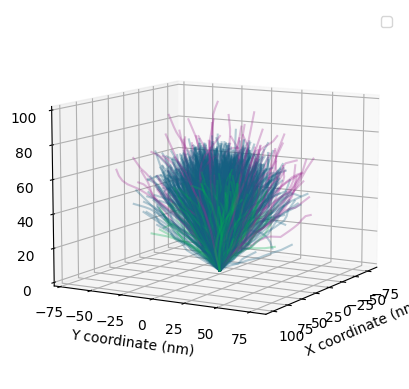

In [93]:
#Plotting the molecules in 3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

result_df = pd.read_csv(cdra_plt_filepath)

plt.ion()

fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
#ax = fig.add_subplot(111, projection='3d')
cmap = ["#00B050", "#156082", "#A02B93"]  #plt.get_cmap('viridis')  # Example: using the 'viridis' colormap
scale = 0.852
tomogram_number = 0
colours = ['Red','Blue','Green','Yellow','Orange']
Previous_tomogram = result_df['Tomogram'].iloc[0]
print(Previous_tomogram)
def plotting(group):
    #print(Current_tomogram)
    ##print(Previous_tomogram)
    #print(tomogram_number)
    #if Current_tomogram == Previous_tomogram:
     #   tomogram_number = tomogram_number
    #else:
     #   tomogram_number = tomogram_number + 1
    #Current_colour = colours[tomogram_number]
    #if Current_tomogram == 'd01t29':
    x = group['x2']*scale
    y = group['y2']*scale
    z = group['z2']*scale
    colour = cmap[(group['Class'].iloc[0] - 1)]
    ax.plot(x,y,z #label=Current_tomogram
            , color=colour
            , alpha = 0.3
            )
    #ax.contour(x,y,z, zdir = 'x', offset=-75, color = colour)
    #Previous_tomogram = group['Tomogram'].iloc[0]

#Each molecule plot as a separate line by grouping the data
result_df.groupby(['Tomogram','Cell','CdrA_molecule']).apply(plotting)
 
#result_df.loc[(result_df['Tomogram']=='d01t29')&(result_df['Cell']==2)].groupby(['CdrA_molecule']).apply(plotting)
ax.view_init(elev=10, azim=30)

# Define a grid of x, y values covering the data range
x_grid, y_grid = np.meshgrid(np.linspace(min(result_df['x2']*scale), max(result_df['x2']*scale), 10),
                              np.linspace(min(result_df['y2']*scale), max(result_df['y2']*scale), 10))

# Constant z value for the plane
z_plane = 29.5
thickness = 0

z_grid = np.full_like(x_grid, z_plane)  # Create a grid filled with z_plane
z_grid_extended = z_grid + thickness  # Extend the z-grid by the specified thickness

# Plot the surface using the extended grid
#ax.plot_surface(x_grid, y_grid, z_grid_extended, alpha=0.3, color='green', linewidth = 10)

# Create a surface (plane) at z = 29.5
#ax.plot_surface(x_grid, y_grid, np.full_like(x_grid, z_plane), alpha=0.3, color='green', zorder=z_plane+thickness)


# plotting
#ax.plot3D(x, y, z, 'green')
#ax.set_title('3D line plot geeks for geeks')
ax.set_xlabel('X coordinate (nm)')
ax.set_ylabel('Y coordinate (nm)')

ax.set_zlabel('Z coordinate (nm)')

ax.legend()

plt.show()

plt.ioff()


Calculating intermolecular distances using only Class 2

In [94]:
#CdrA csv (pre addmodpts as this can alter terminus) is loaded as df1
df1_all = pd.read_csv(cdra_filepath)

#Selecting only length class two (by length)
#print(df1)
df1 = df1_all.loc[(df1_all['Length'] < 83)&(df1_all['Length'] > 61)]

print(df1)

            x         y        z  CdrA_molecule  Cell Tomogram   Distance  \
0     811.076  1055.010  163.527              1     1   d01t11        NaN   
1     816.732  1034.690  163.014              1     1   d01t11  17.976108   
2     827.121  1007.630  162.305              1     1   d01t11  24.703264   
3     835.220   989.321  161.817              1     1   d01t11  17.062381   
4     842.320   979.197  161.524              1     1   d01t11  10.538356   
...       ...       ...      ...            ...   ...      ...        ...   
7156  359.063  1068.430  135.251             39     5   d05t05  11.996149   
7157  364.253  1081.080  149.854             39     5   d05t05  17.044392   
7158  368.942  1090.210  160.806             39     5   d05t05  12.788231   
7159  375.613  1092.810  166.283             39     5   d05t05   7.680286   
7160  378.923  1097.680  172.489             39     5   d05t05   7.288831   

         Length  
0     82.912423  
1     82.912423  
2     82.912423  
3  

In [95]:
#Running the code with this selection

#First coordinatesobtained
coord1 = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(first_coord_df)
#print(coord1)
coord1_df = coord1.reset_index()
coord1_df.drop('level_3',axis=1,inplace=True)


#Second coordinate obtained
coord2 = df1.groupby(['Tomogram','Cell','CdrA_molecule']).apply(last_coord_df)
#print(coord2)
coord2_df = coord2.reset_index()
coord2_df.drop('level_3',axis=1,inplace=True)
#print(coord2_df)

#First and second coordinate dataframes are merged for calculations
coords_df = pd.merge(coord1_df,coord2_df,on=['Tomogram','Cell','CdrA_molecule'])
#print(coords_df)

#Minimal distances between CdrA bases on the same cell are calculated
min_dis1 = coords_df.groupby(['Tomogram','Cell']).apply(nearest_neighbour_base).reset_index(level=[0, 1], drop=True)
#print(min_dis1)
min_dis1_df = min_dis1.reset_index(drop=True)
min_dis1_df.columns = ['Min_Dis_Base_CdrA']

#print(min_dis1_df)

#Minimal distances between CdrA tips on the same cell are calculated
min_dis2 = coords_df.groupby(['Tomogram','Cell']).apply(nearest_neighbour_tip).reset_index(level=[0, 1], drop=True)
#print(min_dis2)
min_dis2_df = min_dis2.reset_index(drop=True)
min_dis2_df.columns = ['Min_Dis_Tip1_CdrA']

#print(min_dis2_df)

#Minimal distances between CdrA tips on different cells are calculated
min_dis3 = coords_df.groupby(['Tomogram']).apply(nearest_neighbour_tip).reset_index(level=[0, 1], drop=True)
#print(min_dis3)
min_dis3_df = min_dis3.reset_index(drop=True)
min_dis3_df.columns = ['Min_Dis_Tip2_CdrA']
#print(min_dis3_df)

#Results are fused into a dataframe
result2_df = pd.merge(min_dis1_df, min_dis2_df, left_index=True, right_index=True)
results_df = pd.merge(result2_df, min_dis3_df, left_index=True, right_index=True)
results_df = pd.merge(results_df, coords_df, left_index=True, right_index=True)
results_df = results_df.drop(columns = ['x1','y1','z1','x2','y2','z2'])
#print(results_df)

#The CdrA_M dataframe is loaded
df2 = pd.read_csv(cdra_M_filepath)
print(df2)

#The calculated distances are merged with the CdrA_M dataframe
merged_df = pd.merge(df2,results_df,on=['Tomogram','Cell','CdrA_molecule'], how='outer')
print(merged_df)

def closest_partner_type_CdrA(row):
    """Determines if the closes partner CdrA tip is on the same cell"""
    Intracellular_dis = row['Min_Dis_Tip1_CdrA']
    Intercellular_dis = row['Min_Dis_Tip2_CdrA']

    if Intercellular_dis == Intracellular_dis:
        # ie the closest CdrA in the tomogram is also the closest CdrA on the same cell, thus the nearest neighbour is on the same cell = Self
        return 'Self'
    #If this condition is not met, the nearest general neighbour must belong to a different cell
    else:
        return 'NonSelf'
    
#The type of the closest partner is calculated and added to the dataframe
merged_df['closest_partner_type_CdrA'] = merged_df.apply(closest_partner_type, axis=1)
print(merged_df)

# #The resultant dataframe is saved over CdrA_M
merged_df.to_csv(cdra_M_filepath, index=False)

        

hello
0
[inf, 705.9928492421152, 609.6073125709696, 553.8676295298363, 520.3293890613905, 712.1436123395337, 620.482739438415, 586.1626084125462, 41.84499823156884, 57.90959895388671, 551.3227225681889]
1
[705.9928492421152, inf, 97.97014886688703, 154.9917936537286, 185.7206307064458, 63.07235705917451, 86.88528241307615, 124.27702893133547, 729.2405046279314, 720.6082943361116, 168.09758263877558]
2
[609.6073125709696, 97.97014886688703, inf, 61.525547417312666, 90.54990472109843, 124.81476755576647, 29.905833360734206, 43.671596501616435, 632.9808112802472, 624.7037580573691, 80.78514274295736]
3
[553.8676295298363, 154.9917936537286, 61.525547417312666, inf, 44.39776852500584, 165.96147306227428, 70.98914198664463, 35.84685274888157, 575.8270692369368, 566.7465063835859, 78.08750371858483]
4
[520.3293890613905, 185.7206307064458, 90.54990472109843, 44.39776852500584, inf, 200.32979314370596, 101.59017398351088, 73.40903447124207, 544.1242159985163, 536.1330539502297, 61.13605889325

In [96]:
#Calculating the number of neighbours closer than a threshold distance

df2 = pd.read_csv(cdra_M_filepath)

min_dis = 10

x = df2.loc[df2['Min_Dis_Tip2_CdrA'] < min_dis]['Cell'].count()
y = df2.loc[df2['Min_Dis_Tip2_CdrA'] > 0]['Cell'].count()
print(x/y)

df2.groupby('Tomogram').count()

print(df2.loc[(df2['Length'] > 61)&(df2['Length'] < 83)]['Mean_curvature'])


0.17035110533159947
0       6.625113e+03
1       8.389966e+12
2       4.420844e+13
5       7.527967e+02
6       1.028364e+04
            ...     
1027    7.397522e+13
1028    3.907489e+03
1030    2.077621e+13
1031             NaN
1034    6.937255e+12
Name: Mean_curvature, Length: 769, dtype: float64


In [97]:
import pandas as pd
import numpy as np

output_filepath = r"C:\Users\callu\OneDrive\Desktop\Python scripts\ideal_coords.csv"


#Ideal molecule calculator
"""
Assumptions:
Curvature is consistent throughout molecule length
Curvature is always positive
"""


#Average molecule length (nm)
molecule_length = 71.4 
#Average radius of curvature (calculated by averaging 1/radius, as absolute values otherwise infinity if perfectly straight)
r = 58.37557062522605 

#Diamter of a circle with the given radius of curvature
diameter = np.pi*r*2

#Calculating points based on their separation will not conserve total molecule length information
# interpoint_distance = 5
# theta = (interpoint_distance/diameter)*2*np.pi
# print(theta)

#The maximum angle of the circle is calculated in radians using the max molecule length given above
theta_max = (molecule_length/diameter)*2*np.pi

#The number of points to generate is given
number_points = 15
increment = theta_max/number_points

#The distance between points in nm that will result is outputted:
interpoint_distance = (increment/(2*np.pi))*diameter
print("Interpoint distance is", interpoint_distance, "nm")

#A list of angles for which to calculate data is calculated from 0 to the max length angle
angle_list = np.arange(0,theta_max+increment,increment)
#print(angle_list)

#For each angle, x and y coordinates are calculated using trigonometry
x_lst = []
y_lst = []
z_lst = []

for i in angle_list:
    #x length subtracted from radius so that the arc starts at the origin
    x = r-(r*np.cos(i))
    y = r*np.sin(i)
    #z coordinate is set to zero, it is redundant
    z = 0
    x_lst.append(x)
    y_lst.append(y)
    z_lst.append(z)
    
data = {
    'x': x_lst,
    'y': y_lst,
    'z': z_lst
}
#print(data)
# Create DataFrame from dictionary
df = pd.DataFrame(data)

df.to_csv(output_filepath, index=False)

Interpoint distance is 4.760000000000001 nm


In [98]:
filtered_df = CdrA_M[CdrA_M['Angle'] > 60]
print(filtered_df)

print(CdrA_M['Length'].mean())

print(CdrA_M[(CdrA_M['Psl'] == 'Y') & (CdrA_M['Class'] == 2)].count())
#430 in length class 2 w/o psl
#339 in length claass 2 w. psl


    Tomogram  Cell  CdrA_molecule     Length  Length_ete  Min_Dis_Base  \
172   d01t28     2             11  70.668467   70.476249     30.489968   
217   d01t29     1             35  74.826231   73.339600     39.270267   
218   d01t29     1             36  68.331459   68.036327     24.657028   
329   d01t33     2             10  99.098470   96.951777     25.050199   
532   d04t05     2              5  81.338834   78.480468     10.654153   
583   d04t19     1              9  77.727307   74.846434      3.125684   
659   d04t20     1             28  80.140883   79.357925     73.311142   
660   d04t20     1             29  73.217187   71.249856     50.897980   
722   d04t22     1              7  65.091534   59.654503      3.701384   
750   d04t22     2             28  60.905018   57.572748     23.716306   
923   d05t05     1             41  67.541737   66.943130     39.134219   
947   d05t05     2             12  57.878722   56.781009     27.597656   
962   d05t05     3              7  53.

In [99]:
#Checking for anomalously curved molecules potentially erroneously generated by addmodpts
CdrA_df = pd.read_csv(addpts_filepath)

filtered_df = CdrA_df[CdrA_df['Radius'] < 4]
print(filtered_df)

           x        y        z  CdrA_molecule  Cell Tomogram  Distance  \
9387  239.44  1157.82  160.555             54     1   d04t05  2.109103   

      Collection  Tomogram_number Psl     Length  Class  Cumulative_distance  \
9387           4                5   N  77.440215      2             27.31006   

        Radius  Straightness  
9387  3.503849      0.902163  
